# KD


### 賴志宏 Chih-Hung Lai

Created: 2021.12.23  Last modified:2021.12.23

## 備註：
- 本講義為自行計算RSI的值，若要呼叫現有的套件，可使用TA-Lib
- [TA-Lib 教學](https://medium.com/ai%E8%82%A1%E4%BB%94/%E7%94%A8-python-%E5%BF%AB%E9%80%9F%E8%A8%88%E7%AE%97-158-%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99-26f9579b8f3a) 

## Table of Contents
1. 介紹KD指標
2. 讀入股票資料  
3. 計算KD線
4. 繪出KD線與股價圖  
5. 策略1：黃金死亡交叉
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
6. 策略2：中線
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗

額外參考資料

# 1. 介紹KD指標

- [KD指標介紹](https://www.cmoney.tw/learn/course/technicals/topic/484)

![](KD.png)

## 2. 讀入股票資料

In [2]:
import pandas as pd
import numpy as np

file = "0050.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2019-12-27   97.60   98.15   97.60   98.00    2978
2019-12-30   98.00   98.25   97.60   97.80    3138
2019-12-31   97.10   97.20   96.95   96.95    4303
2020-01-02   97.05   98.00   97.05   97.65    4882
2020-01-03   98.30   98.70   97.00   97.65    6813
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[300 rows x 5 columns]


## 3. 計算KD線

In [3]:
# Define constants
KD_n = 9
upperBound = 80
lowerBound = 20
middle_line = 50

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

tmp['max_close'] = ticker['Close'].rolling(KD_n, min_periods=1).max()
tmp['min_close'] = ticker['Close'].rolling(KD_n, min_periods=1).min()

# rolling() 的用法可參考 https://vimsky.com/zh-tw/examples/usage/python-pandas-dataframe-rolling.html (modified: Lai)

# RSV also called FastK
tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

data['k'] = np.zeros(ticker.shape[0])
data['d'] = np.zeros(ticker.shape[0])

# skip first day
# because RSV of first day is NaN
for i in range(1, tmp.shape[0]):
    
    # means data['k'][i]
    data.loc[(data.index[i], 'k')] = data['k'][i-1] * (2/3) + tmp['RSV'][i] * (1/3)
    data.loc[(data.index[i], 'd')] = data['d'][i-1] * (2/3) + data['k'][i] * (1/3)

print(data.head(10))

             Open   High    Low  Close  Volume          k          d
Date                                                                
2019-12-27  97.60  98.15  97.60  98.00    2978   0.000000   0.000000
2019-12-30  98.00  98.25  97.60  97.80    3138   0.000000   0.000000
2019-12-31  97.10  97.20  96.95  96.95    4303   0.000000   0.000000
2020-01-02  97.05  98.00  97.05  97.65    4882  22.222222   7.407407
2020-01-03  98.30  98.70  97.00  97.65    6813  37.037037  17.283951
2020-01-06  97.05  97.10  96.40  96.40    9321  24.691358  19.753086
2020-01-07  96.45  96.70  95.40  96.10    6328  16.460905  18.655693
2020-01-08  95.20  96.20  95.05  95.65    8516  10.973937  16.095107
2020-01-09  96.30  97.10  96.30  96.95    7163  25.755674  19.315296
2020-01-10  97.50  97.80  96.95  97.30    9071  42.751845  27.127479


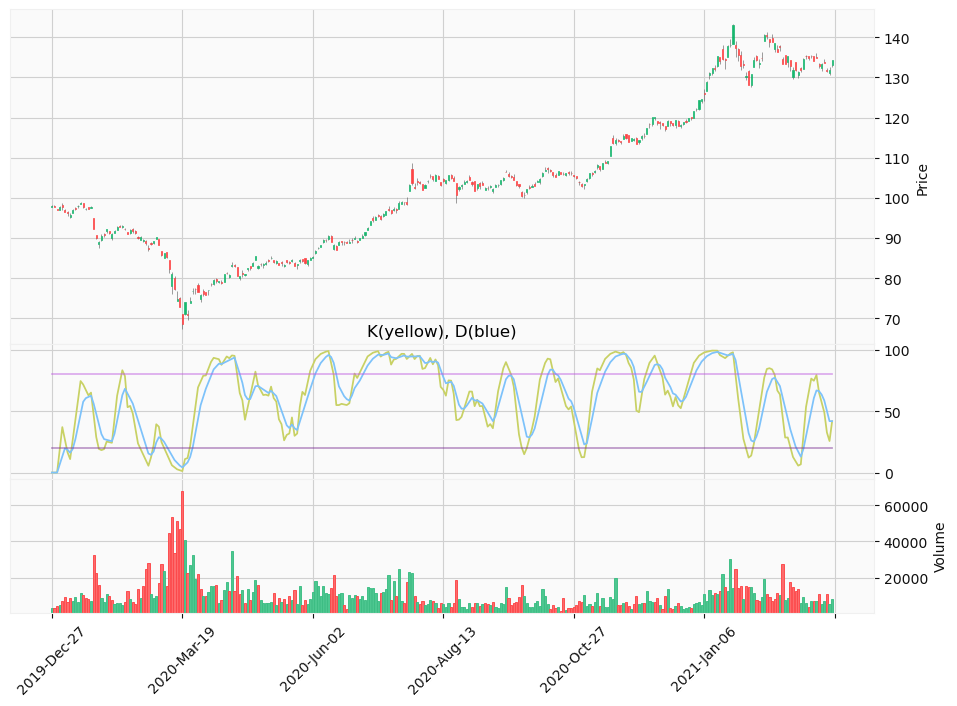

In [4]:
import mplfinance as mpf


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
]

# make the graph(plot)
mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)      

## 4. 策略1：黃金死亡交叉

### 4.1 黃金死亡交叉：策略介紹
用K線與D線的黃金交叉與死亡交叉作為買賣點

買入：K線和D線黃金交叉（K線<20）  
賣出：K線和D線死亡交叉（K線>80）

### 4.2 黃金死亡交叉：策略買賣信號

In [5]:
# initialize 'buy' & 'sell' column by filling with 0
data['buy'] = np.zeros(ticker.shape[0])
data['sell'] = np.zeros(ticker.shape[0])


# skip first KD_n days
for i in range(KD_n, data.shape[0]):

    if(data['k'][i] < 20):
        
        # k upcross d
        if((data['k'][i-1] < data['d'][i-1]) and
           (data['k'][i]   > data['d'][i]) and
           (data['k'][i-1] < data['k'][i])):
            
            data.loc[(data.index[i+1], 'buy')] = 1
            print('buy  |', data.index[i+1], data['Open'][i+1])
            print('k,k-1,d,d-1:\n',data['k'][i],data['k'][i-1],data['d'][i],data['d'][i-1])
    if(data['k'][i] > 80):
        
        # k downcross d
        if((data['k'][i-1] > data['d'][i-1]) and
           (data['k'][i]   < data['d'][i]) and
           (data['k'][i-1] > data['k'][i])):
            
            data.loc[(data.index[i+1], 'sell')] = 1
            print('\nsell |', data.index[i+1], data['Open'][i+1])
            print('k,k-1,d,d-1:\n',data['k'][i+1],data['k'][i-1],data['d'][i],data['d'][i-1])

buy  | 2020-03-23 00:00:00 71.0
k,k-1,d,d-1:
 11.016956083805045 1.1733214496512216 6.473830439458586 4.202267617285358

sell | 2020-04-14 00:00:00 79.05
k,k-1,d,d-1:
 91.86251360887627 92.35732228663825 88.40856455665494 88.7159616283252

sell | 2020-06-12 00:00:00 87.25
k,k-1,d,d-1:
 79.71062733771912 99.000359073937 94.17561223921203 95.80083620504328

sell | 2020-07-13 00:00:00 95.4
k,k-1,d,d-1:
 96.32432689338911 98.93694271733271 95.53181148454014 96.05447205676839

sell | 2020-07-17 00:00:00 97.05
k,k-1,d,d-1:
 91.99424762815343 98.36636750817293 94.02543034733571 97.04245979988852

sell | 2020-07-27 00:00:00 101.8
k,k-1,d,d-1:
 95.01932513599253 96.68821839808851 94.4562053360991 95.41981415215426

sell | 2020-07-30 00:00:00 104.2
k,k-1,d,d-1:
 94.9619035178174 96.67955009066168 94.36259041730621 95.32245798759627

sell | 2020-08-04 00:00:00 102.55
k,k-1,d,d-1:
 85.12718395856585 95.13976751037677 91.31906432308998 94.7548301373322

sell | 2020-08-10 00:00:00 104.1
k,k-1,d,d-1:

### 4.3 黃金死亡交叉：繪製交易點

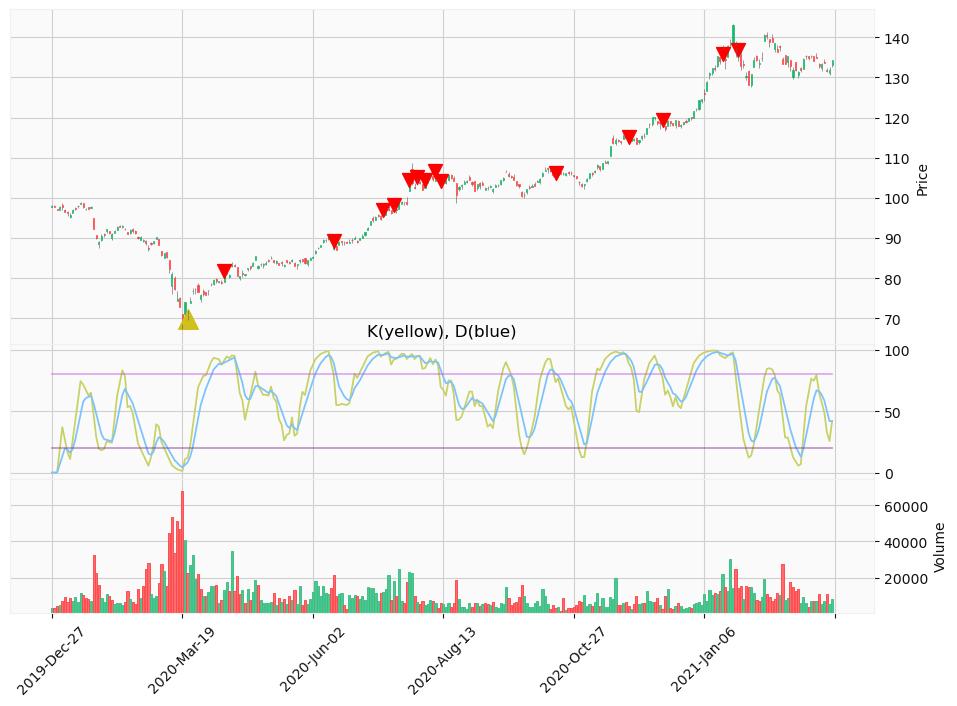

In [9]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)

plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 4.4 黃金死亡交叉：回溯檢驗

In [10]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(row['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    # sell signal or it reach ends
    elif((strategy_3.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      
print()
print('cumulative return rate : {:.3f} %'.format((return_rate-1) * 100))
if(trade_times != 0):
    print('accuracy : {:.3f} %'.format(make_money/ trade_times * 100))

NameError: name 'strategy_3' is not defined

## 5. 策略2：中線

### 5.1 中線：策略介紹
當D線夾在K線和中線中間，可以買賣


買入：9日K > 9日D > 50  
賣出：9日K < 9日D < 50

單純只有這樣的判斷條件，會有太多的信號  
所以加入冷卻時間

### 5.2 中線：策略買賣信號

In [ ]:
# initialize 'buy' & 'sell' column by filling with 0
data['buy'] = np.zeros(ticker.shape[0])
data['sell'] = np.zeros(ticker.shape[0])

cool_down_days = 0
# skip first KD_n days
for i in range(KD_n, data.shape[0]):
    
    # if K > D > 50
    # and cooldown <= 0
    if(data['k'][i] > data['d'][i] > 50 and
       cool_down_days <= 0):
        
        data.loc[(data.index[i], 'buy')] = 1
        print('buy  |', data.index[i])
        
        # reset cooldown
        cool_down_days = KD_n
        
    # if 50 > D > K
    # and cooldown <= 0
    if(data['k'][i] < data['d'][i] < 50 and
       cool_down_days <= 0):
    
        data.loc[(data.index[i], 'sell')] = 1
        print('sell |', data.index[i])
        
        # reset cooldown
        cool_down_days = KD_n
    
    cool_down_days-=1
        

### 5.3 中線：繪製交易點

In [ ]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add middle line
    mpf.make_addplot(np.full((len(data['k'])), middle_line), panel = 1, color='#bf5ce0', alpha=0.5)
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 5.4 中線：回溯檢驗

In [8]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(row['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    # sell signal or it reach ends
    elif((strategy_3.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      
print()
print('cumulative return rate : {:.3f} %'.format((return_rate-1) * 100))
if(trade_times != 0):
    print('accuracy : {:.3f} %'.format(make_money/ trade_times * 100))

NameError: name 'strategy_3' is not defined

## 6. 策略3：交叉帶量

### 6.1 交叉帶量：策略介紹

用K線與D線的交叉帶量與死亡交叉作為買賣點

買入：K線穿出D線 + 大量買入（當日賣出量高於5日均值）  
賣出：K線和D線死亡交叉（K線>80）

### 6.2 交叉帶量：策略買賣信號

In [1]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_3 = pd.DataFrame(index=ticker.index)
strategy_3['buy'] = np.zeros(ticker.shape[0])
strategy_3['sell'] = np.zeros(ticker.shape[0])

strategy_3['vol_5'] = data['Volume'].rolling(5).mean()


# skip first KD_n days
for i in range(KD_n, data.shape[0]):

    if(data['Volume'][i] > strategy_3['vol_5'][i]):
        
        # k upcross d
        if((data['k'][i-1] < data['d'][i-1]) and
           (data['k'][i]   > data['d'][i]) and
           (data['k'][i-1] < data['k'][i])):
            
            strategy_3.loc[(strategy_3.index[i], 'buy')] = 1
            print('buy  |', data.index[i], data['Close'][i])
    if(data['k'][i] > 80):
        
        # k downcross d
        if((data['k'][i-1] > data['d'][i-1]) and
           (data['k'][i]   < data['d'][i]) and
           (data['k'][i-1] > data['k'][i])):
            
            strategy_3.loc[(strategy_3.index[i], 'sell')] = 1
            print('sell |', data.index[i], data['Close'][i])

NameError: name 'pd' is not defined

### 6.3 交叉帶量：繪製交易點

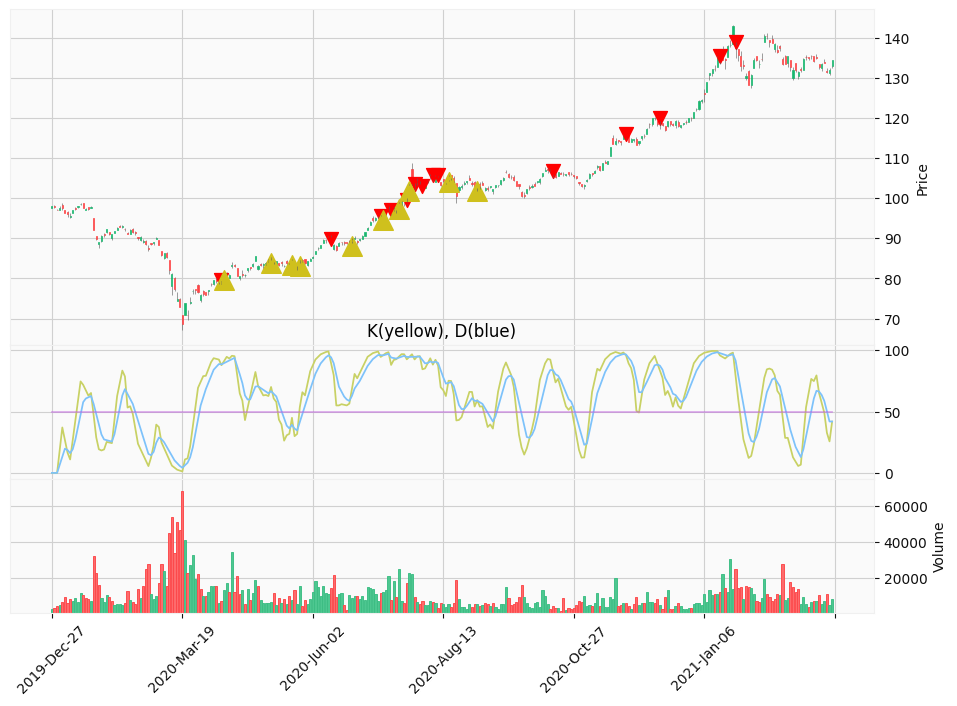

In [134]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_3.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_3.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add middle line
    mpf.make_addplot(np.full((len(data['k'])), middle_line), panel = 1, color='#bf5ce0', alpha=0.5)
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 6.4 交叉帶量：回溯檢驗

In [135]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_3.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    # sell signal or it reach ends
    elif((strategy_3.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate : {:.3f} %'.format((return_rate-1) * 100))
if(trade_times != 0):
    print('accuracy : {:.3f} %'.format(make_money/ trade_times * 100))

buy  | 2020-04-14 00:00:00 |  80.95
buy  | 2020-05-11 00:00:00 |  85.05
buy  | 2020-05-21 00:00:00 |  84.50
buy  | 2020-05-26 00:00:00 |  84.45
sell | 2020-06-11 00:00:00 |  89.05 * 4
buy  | 2020-06-23 00:00:00 |  89.45
sell | 2020-07-10 00:00:00 |  94.65 * 1
buy  | 2020-07-13 00:00:00 |  96.05
sell | 2020-07-16 00:00:00 |  96.10 * 1
buy  | 2020-07-21 00:00:00 |  98.70
sell | 2020-07-24 00:00:00 |  98.50 * 1
buy  | 2020-07-27 00:00:00 | 103.30
sell | 2020-07-29 00:00:00 | 102.55 * 1
buy  | 2020-08-17 00:00:00 | 105.60
buy  | 2020-09-01 00:00:00 | 103.35
sell | 2020-10-15 00:00:00 | 105.70 * 2

cumulative return rate : 12.849 %
accuracy : 66.667 %


## 7. 策略4：交叉帶量+移動停損

### 7.1 交叉帶量+移動停損：策略介紹
用KD線的交叉帶量作為買點，以移動停損做賣點

買入：K線穿出D線 + 大量買入（當日賣出量高於5日均值）  
賣出：低於買入後的最高值10%便賣出

### 7.2 交叉帶量+移動停損：策略買賣信號

In [11]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_4 = pd.DataFrame(index=ticker.index)
strategy_4['buy'] = np.zeros(ticker.shape[0])
strategy_4['sell'] = np.zeros(ticker.shape[0])

strategy_4['vol_5'] = data['Volume'].rolling(5).mean()


top = 0
moving_stop_loss_ratio = 0.1
holding_shares = 0
# skip first KD_n days
for i in range(KD_n, data.shape[0]):

    if(data['Volume'][i] > strategy_4['vol_5'][i]):
        
        # k upcross d
        if((data['k'][i-1] < data['d'][i-1]) and
           (data['k'][i]   > data['d'][i]) and
           (data['k'][i-1] < data['k'][i])):
            
            strategy_4.loc[(strategy_4.index[i+1], 'buy')] = 1
            holding_shares += 1
            print('buy  |', data.index[i+1], data['Open'][i+1])
            
    if(data['Close'][i] < top*(1-moving_stop_loss_ratio)):
        

        strategy_4.loc[(strategy_4.index[i+1], 'sell')] = 1
        holding_shares = 0
        top = 0
        print('sell |', data.index[i+1], data['Open'][i+1])
    
    if(data['Close'][i] > top and holding_shares):
        top = data['Close'][i]

buy  | 2020-04-15 00:00:00 81.25
buy  | 2020-05-12 00:00:00 84.6
buy  | 2020-05-22 00:00:00 83.8
buy  | 2020-05-27 00:00:00 84.7
buy  | 2020-06-24 00:00:00 89.8
buy  | 2020-07-14 00:00:00 95.8
buy  | 2020-07-22 00:00:00 98.55
buy  | 2020-07-28 00:00:00 107.25
buy  | 2020-08-18 00:00:00 105.7
buy  | 2020-09-02 00:00:00 103.65
sell | 2021-02-01 00:00:00 128.2


### 7.3 交叉帶量+移動停損：繪製交易點

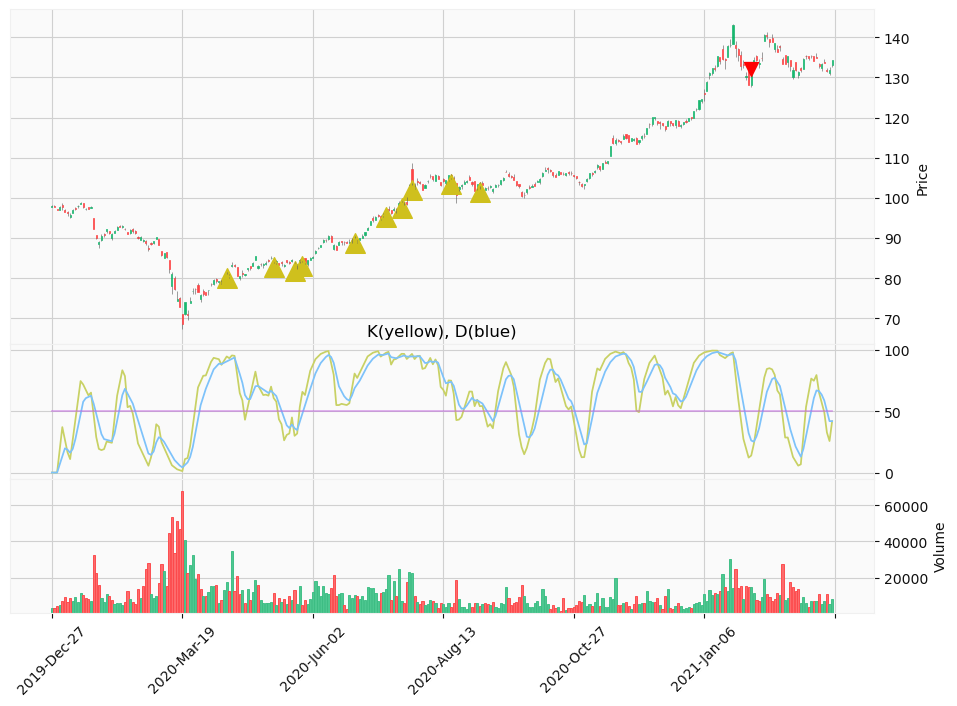

In [12]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_4.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_4.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add middle line
    mpf.make_addplot(np.full((len(data['k'])), middle_line), panel = 1, color='#bf5ce0', alpha=0.5)
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

In [13]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_4.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    # sell signal or it reach ends
    elif((strategy_4.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate : {:.3f} %'.format((return_rate-1) * 100))
if(trade_times != 0):
    print('accuracy : {:.3f} %'.format(make_money/ trade_times * 100))

buy  | 2020-04-15 00:00:00 |  81.20
buy  | 2020-05-12 00:00:00 |  84.05
buy  | 2020-05-22 00:00:00 |  82.95
buy  | 2020-05-27 00:00:00 |  84.35
buy  | 2020-06-24 00:00:00 |  90.00
buy  | 2020-07-14 00:00:00 |  96.65
buy  | 2020-07-22 00:00:00 |  98.95
buy  | 2020-07-28 00:00:00 | 103.60
buy  | 2020-08-18 00:00:00 | 105.00
buy  | 2020-09-02 00:00:00 | 103.00
sell | 2021-02-01 00:00:00 | 130.75 * 10

cumulative return rate : 40.629 %
accuracy : 100.000 %
